In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import arviz as az
az.style.use('arviz-darkgrid')

precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)
insulation = pd.read_excel('data/weather_merignac.xlsx', sheet_name='insulation', index_col=0)

ratings = pd.read_excel('data/ratings.xlsx', index=False, encoding = 'ascii')
#ratings = ratings[ratings['Category']=='Premier cru 1855']
selected_vineyards = list(ratings['Chateau'].unique())
print(selected_vineyards)

ratings['Rating - Avg'] = (ratings['Rating - LB'] + ratings['Rating - HB'])/2
ratings = ratings.groupby('Vintage')['Rating - Avg'].mean().to_frame()


prices = pd.read_excel('data/prices.xlsx', index_col=0)
df = prices.drop('Category', axis=1).transpose().reset_index().melt(id_vars='index').rename(columns={'index':'Vintage', 'variable':'Chateau', 'value':'Price'})[['Chateau','Vintage','Price']]
df = df.replace(-100, np.NaN)
selected_prices = df[(df['Chateau'].isin(selected_vineyards))].fillna(method='ffill')
display(selected_prices['Chateau'].unique())
prices = selected_prices.groupby('Vintage')['Price'].mean().to_frame()

['Château Lafite Rothschild Pauillac', 'Château Latour Pauillac', 'Château Mouton Rothschild Pauillac', 'Château Cheval Blanc', 'Château Ausone', 'Château Margaux', 'Château Haut-Brion Pessac-léognan', 'Château Angélus', 'Château Trotte Vieille', 'Château Palmer', 'Petrus Pomerol']


array(['Château Lafite Rothschild Pauillac', 'Château Latour Pauillac',
       'Château Mouton Rothschild Pauillac', 'Château Margaux',
       'Château Haut-Brion Pessac-léognan', 'Château Ausone',
       'Château Cheval Blanc', 'Château Trotte Vieille',
       'Château Angélus', 'Château Palmer', 'Petrus Pomerol'],
      dtype=object)

# Feature engineering

In [53]:
X = pd.DataFrame(index = precipitations.index)

X['Winter Rain'] =  precipitations.shift(1)['Dec'] # really important

#X['Square Winter Rain'] =  X['Winter Rain']**2

X['Harvest Rain'] =  precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou']+ precipitations['Sep']*2

#X['Square Harvest Rain'] =  X['Harvest Rain']**2



X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])

#X['Square Winter Temperature'] = X['Winter Temperature']**2

X['Summer Temperature'] = \
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui'])*2+\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

#X['Square Summer Temperature'] = X['Summer Temperature']**2


X['Harvest Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])*3+\
                    (temp_maximals['Oct'] + temp_minimals['Oct'])*2


#X['Square Harvest Temperature'] = X['Harvest Temperature']**2


#X['Frost Days'] = frost_days['Mar']+ 3*frost_days['Avr']+ 3*(frost_days['Mai'] + frost_days['Jui'])

#X['Square Frost Days'] = X['Frost Days']**2

#X['Insulation'] = insulation.iloc[:,0] # negative on mean r2 and bad scores

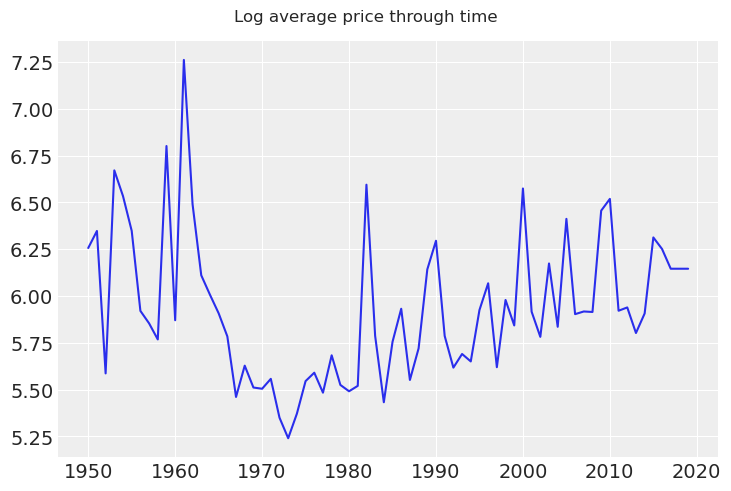

In [54]:
y = prices
y['Log Price'] = np.log(y['Price'])
sns.lineplot(data=y['Log Price'])
plt.suptitle('Log average price through time')
plt.show()

# Building the model

In [55]:
from sklearn.preprocessing import StandardScaler

X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns).loc[1950:,:]

y['LP2'] = y['Log Price']
print(y['LP2'])



Vintage
1950    6.256622
1951    6.347548
1952    5.586908
1953    6.671227
1954    6.533657
          ...   
2015    6.313054
2016    6.251378
2017    6.145940
2018    6.145940
2019    6.145940
Name: LP2, Length: 70, dtype: float64


In [56]:
import pymc3 as pm

display(y)
y['lag']=y['LP2'].shift(1).fillna(0)

with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1./.02, testval=.1) # Random walk jump size
    
    nu = pm.Exponential('nu', 1./10) # Observation noise
    
    
    winter_rain_coeff = pm.GaussianRandomWalk('winter rain coeff', sigma**-2, shape=len(y))
    summer_temperature_coeff = pm.GaussianRandomWalk('summer temperature coeff', sigma**-2, shape=len(y))
    intercept = pm.GaussianRandomWalk('intercept', sigma**-2, shape=len(y))
    
    observed = pm.Normal('observed', mu=6+intercept+winter_rain_coeff*X['Winter Rain'] + summer_temperature_coeff*X['Summer Temperature'], sd=1/nu, observed=y['LP2'])
    trace = pm.sample()

,Price,Log Price,LP2
Vintage,,,
1950,521.454545,6.256622,6.256622
1951,571.090909,6.347548,6.347548
1952,266.909091,5.586908,5.586908
1953,789.363636,6.671227,6.671227
1954,687.909091,6.533657,6.533657
...,...,...,...
2015,551.727273,6.313054,6.313054
2016,518.727273,6.251378,6.251378
2017,466.818182,6.145940,6.145940


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, summer temperature coeff, winter rain coeff, nu, sigma]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████| 4000/4000 [01:06<00:00, 59.84draws/s]
The acceptance probability does not match the target. It is 0.9168936763454949, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


0.0415879634979148


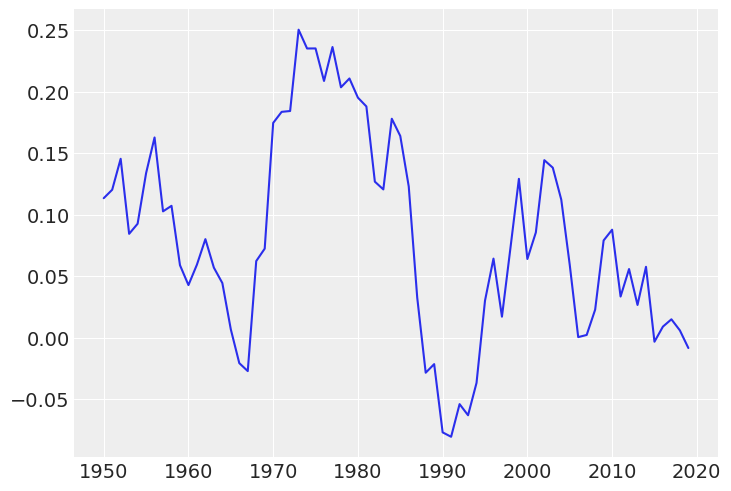

           0         1         2         3         4         5
0   0.048478  0.185639  0.060865  0.258525  0.304668  0.113386
1   0.035746  0.180515  0.070833  0.201670  0.233993  0.120241
2   0.034070  0.160745  0.122248  0.135840  0.183990  0.145407
3   0.065279  0.125567  0.150868  0.144661  0.129565  0.084419
4   0.086190  0.094446  0.134413  0.088345  0.087777  0.092607
..       ...       ...       ...       ...       ...       ...
65 -0.008647 -0.087589  0.091724 -0.055244 -0.001344 -0.003258
66 -0.010967 -0.078019  0.060883 -0.015814 -0.009081  0.009033
67  0.009614 -0.036760  0.071834 -0.011509  0.015498  0.014956
68  0.037247 -0.002467  0.005245  0.026227  0.031841  0.005935
69  0.023490  0.014808 -0.027620  0.038072 -0.000315 -0.008376

[70 rows x 6 columns]


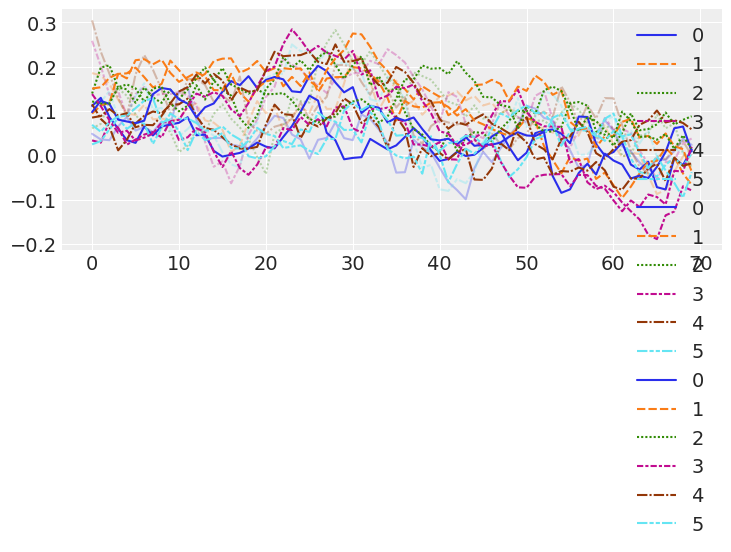

In [57]:
print(trace['sigma'][-1])
plt.plot(y.index, trace['winter rain coeff'][-1,:])
plt.show()
#plt.plot(y.index, 6+trace['intercept'][-1,:]+trace['winter rain coeff'][-1,:]*X['Winter Rain']+trace['summer temperature coeff'][-1,:]*X['Summer Temperature'], color='r')
arr = trace['winter rain coeff'][-6:,:].T
print(pd.DataFrame(arr))
sns.lineplot(data=arr, hue='g',alpha=0.3)
sns.lineplot(data=trace['winter rain coeff'][-12:-6,:].T)
sns.lineplot(data=trace['winter rain coeff'][-18:-12,:].T)

#plt.plot(y.index, y['LP2'], color='g')

C:\Users\Rico\Anaconda3\lib\site-packages\pymc3\plots\traceplot.py:148: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000256A410F370>,
      dtype=object)

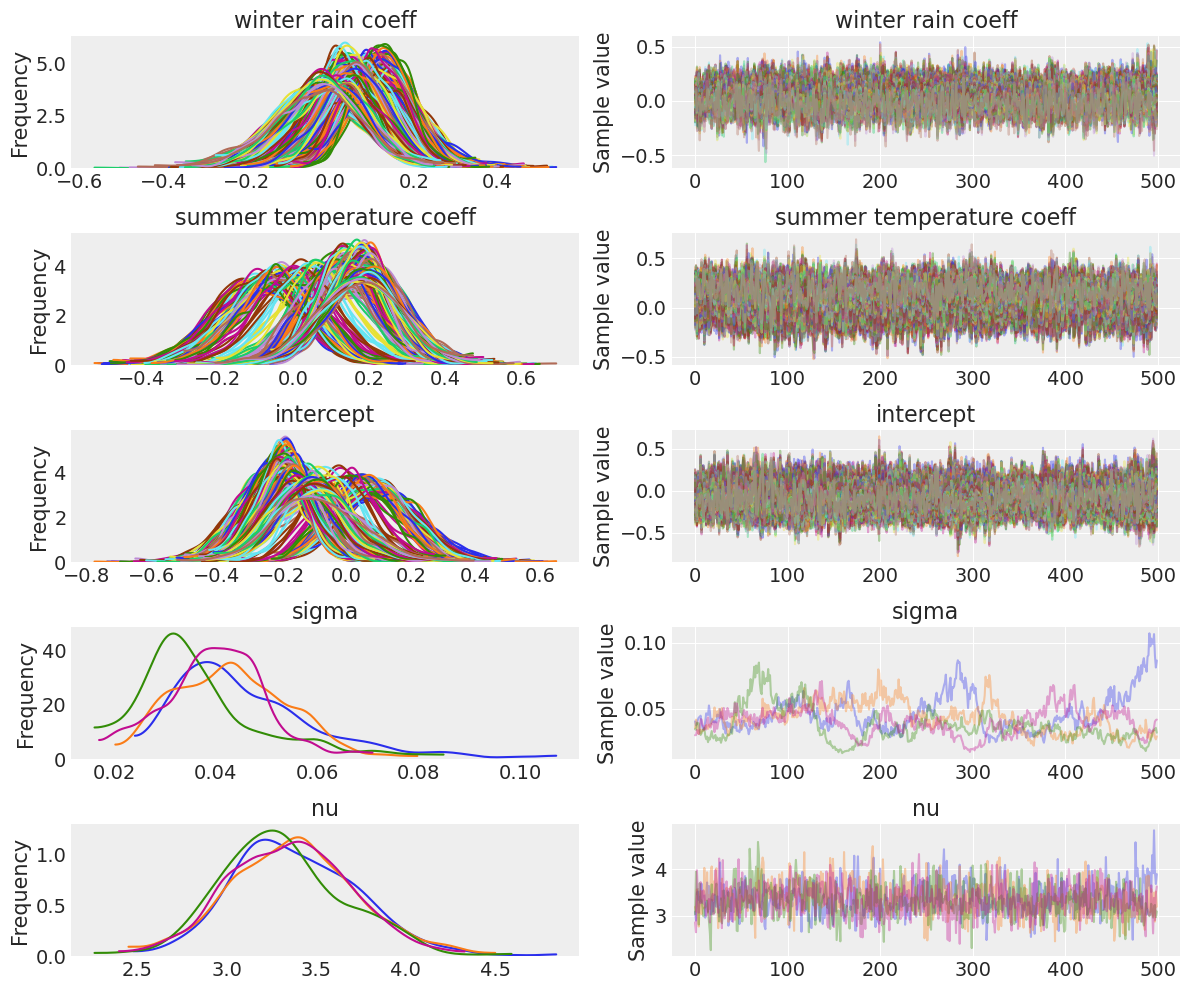

In [58]:
pm.traceplot(trace)